In [1]:
import os
import time
import gnupg
import keyring
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from binance.spot import Spot
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
gpg = gnupg.GPG()
encrypted_file_path = os.path.expanduser('~/Repositorios/binance_trader/.env.gpg')
with open(encrypted_file_path, 'rb') as file:
    datos = gpg.decrypt_file(file, passphrase=keyring.get_password("GPG_Passphrase", "gpg_python"))
if datos.ok:
    env_vars = dict(line.decode('utf-8').split('=', 1) for line in datos.data.splitlines())
    api_key = env_vars.get('API_KEY')
    secret_key = env_vars.get('SECRET_KEY')
# Inicializa el cliente de Binance
client = Spot(api_key, secret_key)

In [3]:
def get_historical_data(symbols, interval='1d'):
    data_frames = {}
    
    for symbol in symbols:
        start_time = 0
        data = []
        
        while True:
            # Obtener datos de klines
            klines = client.klines(symbol=symbol, interval=interval, limit=1000, startTime=start_time)
            # Si no hay más datos, salir del bucle
            if not klines:
                break
            for kline in klines:
                data.append({
                    'open_time': kline[0],
                    #'open': float(kline[1]),
                    #'high': float(kline[2]),
                    #'low': float(kline[3]),
                    'close': float(kline[4]),
                    #'volume': float(kline[5]),
                    #'quote_asset_volume': float(kline[7]),
                    #'number_of_trades': kline[8],
                    #'taker_buy_base_asset_volume': float(kline[9]),
                    #'taker_buy_quote_asset_volume': float(kline[10])
                })
            # Actualizar start_time para la próxima solicitud
            start_time = klines[-1][0] + 1
        data_frames[symbol] = pd.DataFrame(data)
    # Crear el dataframe multinivel
    df_list = []
    for symbol, df in data_frames.items():
        df = df.set_index('open_time')
        df.index.name = 'date'
        df.index = pd.to_datetime(df.index, unit='ms')
        df.columns = pd.MultiIndex.from_product([[symbol], df.columns])
        df_list.append(df)
    final_df = pd.concat(df_list, axis=1)
    return final_df
# Descarga de datos de activos
symbols = ['HBARUSDT', 'XRPUSDT']
df = get_historical_data(symbols).dropna()

In [4]:
# Cálculo de la frontera eficiente
def calculate_efficient_frontier(df_returns, alpha=0.5):
    def objective_function(weights, cov_matrix, expected_returns):
        portfolio_return = np.dot(weights, expected_returns) * 365  
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(365)
        sharpe_ratio = portfolio_return / portfolio_volatility
        # Función objetivo combinada
        return alpha * (-sharpe_ratio) + (1 - alpha) * portfolio_volatility

    expected_returns = df_returns.mean()
    cov_matrix = df_returns.cov()
    symbols = df_returns.columns.to_list()
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = tuple((0, 1) for _ in symbols)
    initial_weights = np.array([1.0 / len(symbols)] * len(symbols))
    result = minimize(objective_function, initial_weights, args=(cov_matrix, expected_returns),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        optimal_weights = result.x
        optimal_return = np.dot(optimal_weights, expected_returns) * 365
        optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(365)
        optimal_sharpe = optimal_return / optimal_volatility
        return {'symbols': symbols, 'weights': optimal_weights, 'return': optimal_return, 'volatility': optimal_volatility, 'sharpe_ratio': optimal_sharpe}

# Obtener datos históricos y calcular los pesos óptimos
df_returns = df.xs('close', level=1, axis=1).pct_change().dropna()
dict_ef = calculate_efficient_frontier(df_returns)

{'symbols': ['HBARUSDT', 'XRPUSDT'],
 'weights': array([0.41533372, 0.58466628]),
 'return': np.float64(0.8116715064995654),
 'volatility': np.float64(1.0003745956528955),
 'sharpe_ratio': np.float64(0.8113675717342933)}

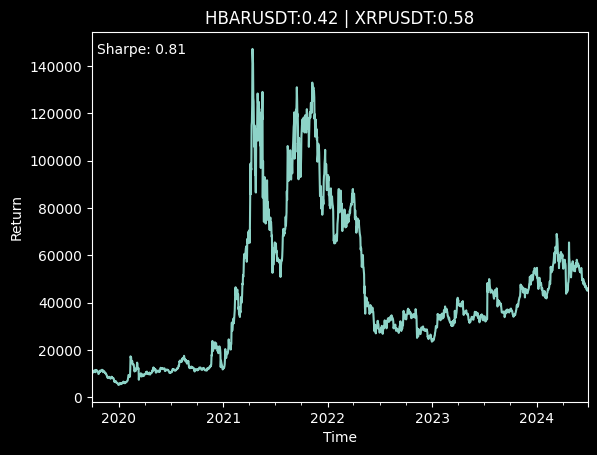

In [23]:
# Calcula los retornos diarios del portafolio
df_returns['portfolio_return'] = 10_000 * (1 + df_returns[['HBARUSDT', 'XRPUSDT']].dot(dict_ef['weights'])).cumprod()
ax = df_returns['portfolio_return'].plot(
    title=(f"{dict_ef['symbols'][0]}:{dict_ef['weights'][0]:.2f} | "
           f"{dict_ef['symbols'][1]}:{dict_ef['weights'][1]:.2f}"),
    xlabel='Time',
    ylabel='Return'
    )
ax.text(x=0.01,
        y=0.97,
        s=f'Sharpe: {dict_ef["sharpe_ratio"]:.2f}',
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left')
plt.show()